In [1]:
import warnings

warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

import numpy as np
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 0

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# Peaks data
from scipy.io import mmread

%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 120

sc.set_figure_params(figsize=(4,4),dpi=120)

In [2]:
import os
os.chdir('/lustre/scratch/kiviaho/spatac/')

## ATAC Preprocessing from ArchR output

In [3]:
# ATAC PREPROCESSING ACCORDING TO:
# https://github.com/dpeerlab/SEACells/blob/main/notebooks/ArchR/ArchR-preprocessing.ipynb
data_dir = '/lustre/scratch/kiviaho/spatac/data/tonsilatlas/scATAC-seq/ArchR/tonsil_atac/export/'

In [4]:
counts = mmread(data_dir + 'peak_counts/counts.mtx')

In [5]:
# Downloatac cell and peak information 
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()

,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,nearestGene,distToGeneStart,peakType,distToTSS,nearestTSS,GC,idx,N
chr1:817152-817652,chr1,817152,817652,501,*,2.73122,0.324,0.068,2,C5._.Rep2,FAM87B,31,Promoter,30,uc057aum.1,0.4950,1,0
chr1:827315-827815,chr1,827315,827815,501,*,213.42300,0.915,0.855,2,C9._.Rep1,LINC01128,2427,Promoter,42,uc057auo.1,0.6966,2,0
chr1:857888-858388,chr1,857888,858388,501,*,11.04600,0.622,0.236,2,C2._.Rep1,LINC01128,33000,Exonic,6789,uc057auo.1,0.3752,3,0
chr1:865571-866071,chr1,865571,866071,501,*,70.11230,0.839,0.664,2,C5._.Rep1,FAM41C,2250,Distal,4379,uc057aux.1,0.4431,4,0
chr1:869631-870131,chr1,869631,870131,501,*,154.18100,0.881,0.799,2,C9._.Rep1,FAM41C,1810,Intronic,319,uc057aux.1,0.7166,5,0


In [6]:
# Create anndata object and atacd annotations
atac = sc.AnnData(counts.T)
atac.obs_names = cells
atac.var_names = peaks.index
for col in peaks.columns:
    atac.var[col] = peaks[col]

atac.X = atac.X.tocsr()
atac.raw = atac.copy()

atac.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[atac.obs_names, : ].values

cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[atac.obs_names, : ]
for col in cell_meta.columns:
    atac.obs[col] = cell_meta[col].values

# Gene scores
gene_scores = pd.read_csv(data_dir + 'gene_scores.csv', index_col=0).T

atac.obsm['GeneScores'] = gene_scores.loc[atac.obs_names, :].values
atac.uns['GeneScoresColums'] = gene_scores.columns.values

atac.obs_names = [bc.split('#')[1] for bc in atac.obs_names] # remove archr project identifier
atac

/tmp/ipykernel_29436/661737169.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atac = sc.AnnData(counts.T)


KeyboardInterrupt: 

### Plot ATAC in a UMAP space to determine "cell types"

In [21]:
# Leiden and UMAP for ATAC data
warnings.filterwarnings('ignore')
sc.pp.neighbors(atac, use_rep='X_svd')
sc.tl.umap(atac)
sc.tl.leiden(atac,resolution=0.6)
warnings.filterwarnings('default')

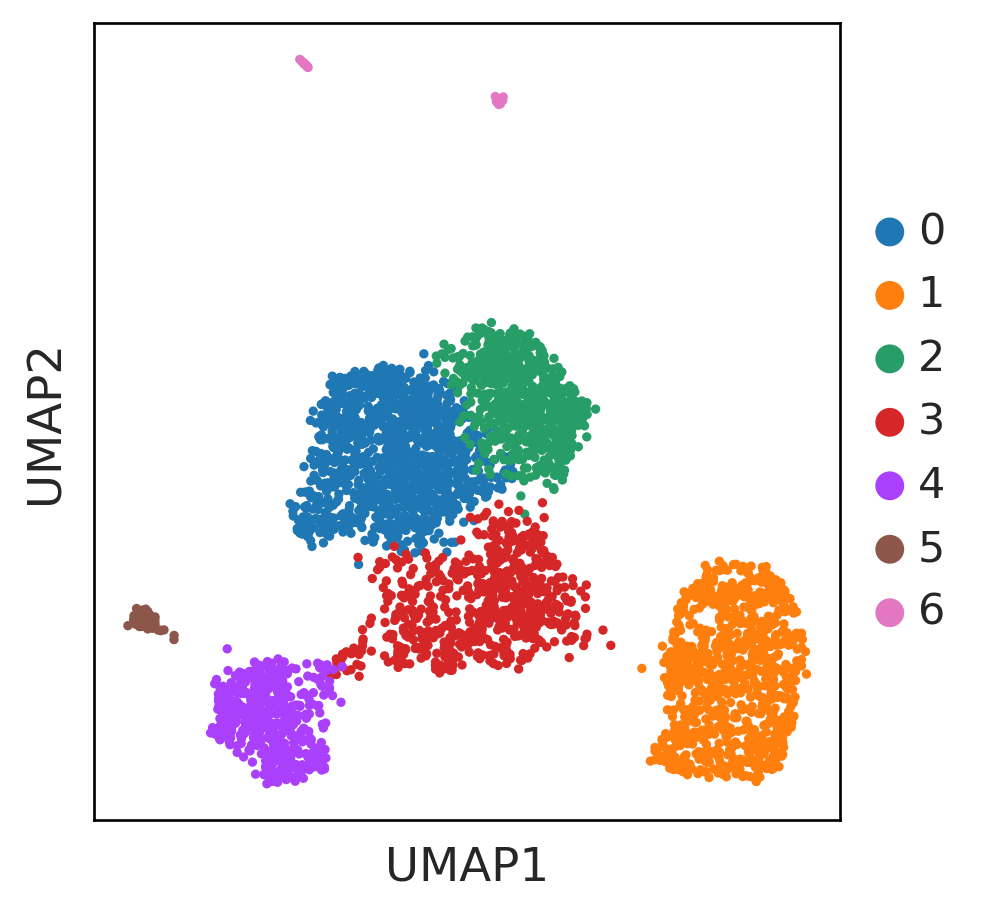

In [35]:
sc.pl.scatter(atac,basis='umap',color='leiden',title='',frameon=True,show=True,color_map='Set2')

In [26]:
# Plot UMAPs for saving
# With cluster markers
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(12,8)
sc.pl.scatter(atac,basis='umap',color='leiden',title='',ax=ax1,frameon=True,show=False,color_map='Set2')
fig.tight_layout()
plt.savefig('./plots/tonsil-single-cell-atac-scatter-with-own-leiden-clusters-cluster-example.png',dpi=600)
plt.clf()



fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(4,4)
sc.pl.scatter(atac,basis='umap',color='leiden',title='',ax=ax1,legend_loc='none',frameon=False,show=False)
plt.savefig('./plots/tonsil-single-cell-atac-scatter-with-own-leiden-clusters.png',dpi=600)
plt.clf()


<Figure size 1440x960 with 0 Axes>

<Figure size 480x480 with 0 Axes>

### Preprocess RNA from 10x output

In [28]:

rna = sc.read_10x_h5('./data/tonsilatlas/spatial_transcriptomics/BCLLATLAS_32/esvq52_nluss5/filtered_feature_bc_matrix.h5')
# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_rna = sc.AnnData(rna.X)
raw_rna.obs_names, raw_rna.var_names = rna.obs_names, rna.var_names
rna.raw = raw_rna
rna

/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3079 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [29]:
atac.write('./data/atac_tonsil_scatac_BCLL10_T.h5ad')
rna.write('./data/rna_tonsil_spatial_BCLL10_T.h5ad')


# Simulating possible cell compositions for "spatial ATAC"

In [52]:
## Function definitions ###

def cartesian(*arrays):
    """Makes the Cartesian product of arrays.

    Parameters
    ----------
    arrays: N-D array-like
            N-D arrays where earlier arrays loop more slowly than later ones
    """
    N = len(arrays)
    arrays_np = [np.asarray(x) for x in arrays]
    arrays_2d = [x[:, None] if np.asarray(x).ndim == 1 else x for x in arrays_np]
    arrays_integer = [np.arange(len(x)) for x in arrays_2d]
    product_integers = np.stack(np.meshgrid(*arrays_integer, indexing="ij"), -1).reshape(-1, N)
    return np.concatenate(
        [array[product_integers[:, i]] for i, array in enumerate(arrays_2d)], axis=-1
    )

def kernel(X1, X2, l=1.0, eta=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return eta**2 * np.exp(-0.5 / l**2 * sqdist)
    
def generate_grid(
              n=[50, 50] #spatial dimensions 
):
    n1, n2 = n 
    x1 = np.linspace(0, 100, n1)[:,None] #saptial dimensions 
    x2 = np.linspace(0, 100, n2)[:,None] #saptial dimensions 

    # make cartesian grid out of each dimension x1 and x2
    return cartesian(x1[:,None], x2[:,None]), x1, x2

def random_GP(X, x1=1, x2=1, #coordinates
              n_variables = 5, #zones
              eta_true = 5, #variance, defines overlapping
              l1_true=[8, 10, 15], #bw parameter
              l2_true=[8, 10, 15]
             ):

    #cov1, cov2 = kernel(x1, x1, l=l1_true), kernel(x2, x2, l=l2_true)
    K = [np.kron(kernel(x1, x1, l=l1_true[i], eta=eta_true), 
                 kernel(x2, x2, l=l2_true[i], eta=eta_true)) 
         for i in range(n_variables)]

    gaus_true = np.stack([np.random.multivariate_normal(np.zeros(X.shape[0]), 
                                                        2*K[i]) 
                          for i in range(n_variables)]).T #samples from GP
    N_true = (np.exp(gaus_true).T / np.exp(gaus_true).sum(axis=1)).T #softmax transform, eq 48
    return N_true


def plot_spatial(values, n=[50,50], nrows=5, names=['cell type'],
                 vmin=0, vmax=1):
    
    n_cell_types = values.shape[1]
    n1, n2 = n 
    ncols = int(np.ceil((n_cell_types+1) / nrows))
    for ct in range(n_cell_types):
        plt.subplot(nrows, ncols, ct+1)
        plt.imshow(values[:,ct].reshape(n1,n2).T, 
                   cmap=plt.cm.get_cmap('magma'),
                   vmin=vmin, vmax=vmax
                  )
        plt.colorbar()
        if len(names) > 1:
            plt.title(names[ct])
        else:
            plt.title(f'{names[0]} {ct+1}')

    plt.subplot(nrows, ncols, n_cell_types+1) 
    plt.imshow(values.sum(axis=1).reshape(n1,n2).T, 
               cmap=plt.cm.get_cmap('Greys'))
    plt.colorbar()
    plt.title('total')


In [37]:

n_locations = [50, 50] 
n_experiments = 12 # Change to 10 when creating actual data
n_zones = 70

# controls for the average number of cells present
mu_density = 5

# Neg binomial prob --- controls the number of cell types present in a given zone
prob = 0.98 # Adjust this 0.9-0.99

## simulation settings
seed = 45746 # changed from 253286


In [39]:
## simulation settings
np.random.seed(seed)

## generate per cell type simulation attributes
cell_types = np.array(atac.obs['leiden'].unique())
n_cell_types = len(cell_types)

# generate matrix of which cell types are in which zones
cell_type_zones = pd.DataFrame(0, index=cell_types, 
                                columns=[f'zone_{i}' for i in range(n_zones)])


# choose 1 to n_cell_type cell types inside each location by choice
dist = np.random.negative_binomial(n_cell_types**2,prob,100000) + 1
dist = dist[(dist <= n_cell_types)]

for i, n in enumerate(cell_type_zones):
    types = np.random.choice(cell_types,np.random.choice(dist),replace=False)
    row_idx = np.where(cell_type_zones.index.isin(types))
    cell_type_zones.iloc[row_idx,i] = 1
    


In [40]:
np.random.seed(seed)
#Generate average abundance for low and high density cell types
mean_var_ratio = 5

gamma_multipliers = np.empty(shape=(n_cell_types,0))

for i in range(len(cell_type_zones.columns)):
    cell_types_present = cell_type_zones[cell_type_zones.columns[i]].sum()
    
    gamma_multipliers = np.hstack([gamma_multipliers,
                              np.random.gamma((mu_density-cell_types_present) * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(cell_type_zones), 1))])
    
cell_type_zones = cell_type_zones * gamma_multipliers

In [41]:
cell_type_zones

,zone_0,zone_1,zone_2,zone_3,zone_4,zone_5,zone_6,zone_7,zone_8,zone_9,...,zone_60,zone_61,zone_62,zone_63,zone_64,zone_65,zone_66,zone_67,zone_68,zone_69
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.437025,0.000000,0.000000,0.000000,1.839806,0.000000,0.00000,0.000000,0.000000
0,2.672085,0.000000,0.000000,1.849954,0.000000,0.000000,0.000000,0.000000,0.000000,3.686576,...,2.567434,0.000000,0.000000,0.000000,0.000000,0.000000,1.648308,0.00000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,3.842857,2.976864,0.000000,3.541864,0.000000,3.801553,...,1.568356,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.708773,3.335697
2,0.000000,0.000000,2.455783,0.000000,2.673703,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.831052,2.941039,3.821618,0.000000,0.000000,3.67167,3.802536,0.000000
1,3.631882,0.000000,4.325301,0.000000,0.000000,0.000000,0.000000,0.000000,5.210954,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.890311,1.374113,0.00000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.307838,0.000000,0.000000,0.000000,...,0.000000,2.582662,3.605623,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
5,0.000000,3.842583,0.000000,0.000000,0.000000,0.000000,2.379298,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.860922,0.000000,1.915767,2.023503,0.00000,0.000000,0.000000


In [42]:
# Gaussian process over the spatial grids, takes about an hour, for 20 50x50 grids.
np.random.seed(seed)
# Sample bw parameter
mean_var_ratio = 1.2
mean = 8
tissue_zones_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                       size=(n_zones))

def sample_GP(locations, x1, x2):
    # Sample abundances with GP
    abundances = random_GP(X=locations, x1=x1, x2=x2, n_variables=n_zones, 
                                                    eta_true=1.5,
                                                    l1_true=tissue_zones_l1_true,
                                                    l2_true=tissue_zones_l1_true)
    abundances = abundances / abundances.max(0)
    abundances[abundances < 0.1] = 0
    
    return pd.DataFrame(abundances, 
                                 index=[f'location_{i}' for i in range(abundances.shape[0])],
                                 columns=cell_type_zones.columns
                                )

locations_1, x1, x2 = generate_grid(n=n_locations)
locations = np.concatenate([locations_1 for _ in range(n_experiments)], axis=0)

abundances_df = pd.DataFrame()

for e in range(n_experiments):
    print('Working on experiment '+ str(e))
    abundances = random_GP(X=locations_1, x1=x1, x2=x2, n_variables=n_zones, 
                                                    eta_true=1.5,
                                                    l1_true=tissue_zones_l1_true,
                                                    l2_true=tissue_zones_l1_true)
    abundances = abundances / abundances.max(0)
    abundances[abundances < 0.1] = 0
    
    abundances_df_1 = pd.DataFrame(abundances, 
                                 index=[f'location_{i}' for i in range(abundances.shape[0])],
                                 columns=cell_type_zones.columns
                                )
    
    abundances_df_1.index = [f'exper{e}_{l}' for l in abundances_df_1.index]
    abundances_df = pd.concat((abundances_df, abundances_df_1), axis=0)
    

Working on experiment 0
Working on experiment 1
Working on experiment 2
Working on experiment 3
Working on experiment 4
Working on experiment 5
Working on experiment 6
Working on experiment 7
Working on experiment 8
Working on experiment 9
Working on experiment 10
Working on experiment 11


In [43]:
# HERE w_sf = sum_r(z_sr,x_rf)*q_sf
np.random.seed(seed)
cell_abundances = np.dot(abundances_df, cell_type_zones.T)
cell_abundances = cell_abundances * np.random.lognormal(0, 0.35, size=cell_abundances.shape)
cell_abundances_df = pd.DataFrame(cell_abundances, 
                             index=abundances_df.index,
                             columns=cell_type_zones.index
                            )

cell_count_df = np.ceil(cell_abundances_df)        

In [44]:
cell_count_df

,3,0,4,2,1,6,5
exper0_location_0,2.0,2.0,1.0,3.0,1.0,2.0,0.0
exper0_location_1,0.0,3.0,1.0,2.0,1.0,2.0,0.0
exper0_location_2,0.0,2.0,3.0,2.0,1.0,2.0,0.0
exper0_location_3,1.0,3.0,1.0,1.0,1.0,1.0,0.0
exper0_location_4,1.0,2.0,2.0,1.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...
exper11_location_2495,4.0,0.0,1.0,0.0,0.0,0.0,0.0
exper11_location_2496,3.0,0.0,1.0,0.0,0.0,0.0,0.0
exper11_location_2497,1.0,0.0,1.0,0.0,0.0,1.0,0.0
exper11_location_2498,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [46]:
cell_count_df.to_csv('/lustre/scratch/kiviaho/spatac/integrations/tonsilatlas/actual_scatac_to_spatial/simulated-atac-cell-count-matrix.csv')

/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


mean n cells: 7.606633333333333


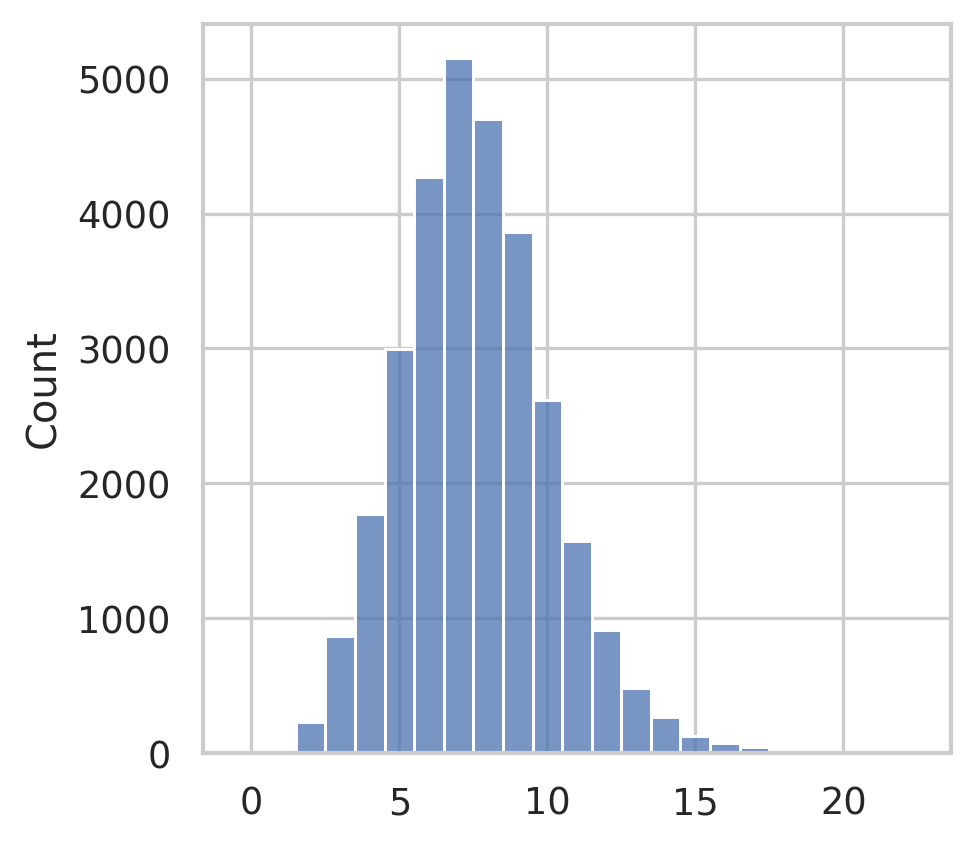

In [48]:
plt.figure(figsize=(4,4),dpi=120)
sns.set_theme(style='whitegrid')
sns.histplot(cell_count_df.sum(axis=1),discrete=True,binrange=(0,22))
plt.savefig('./plots/tonsil-scatac-simulated-spatial-cell-count-histplot.png',dpi=600)
#plt.title('The number of diferent cell types in spatial spots')
print('mean n cells: '+str(cell_count_df.sum(axis=1).mean()))


/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


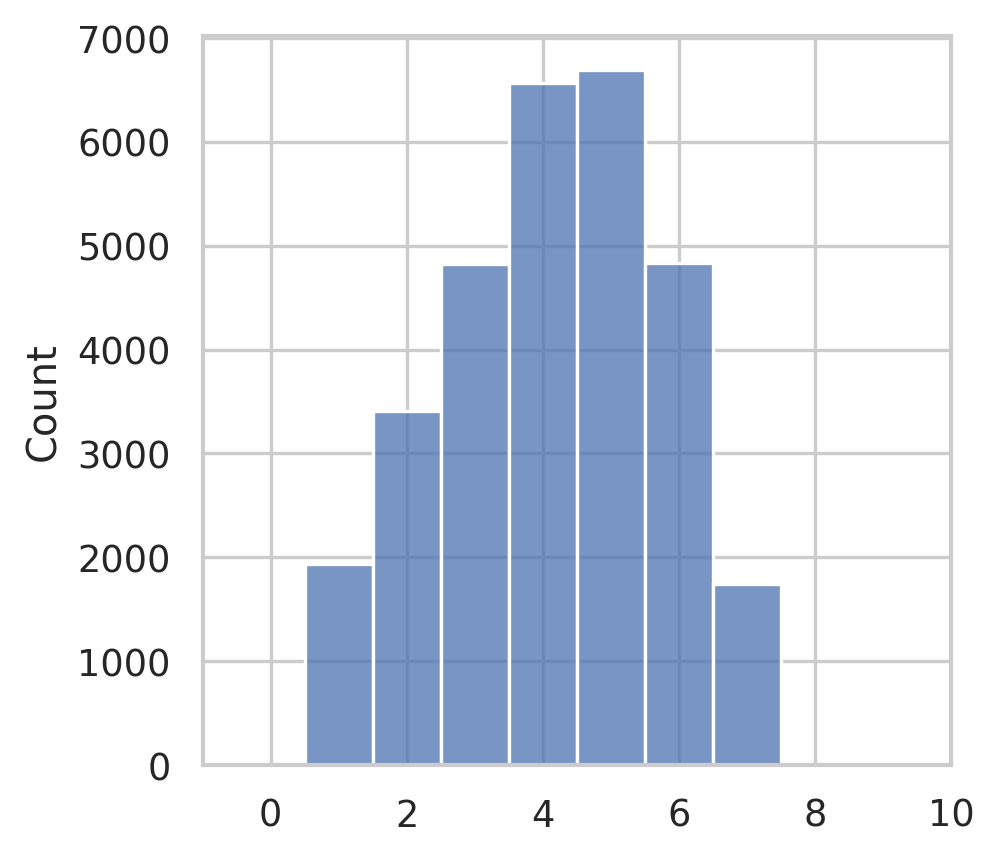

In [49]:
plt.figure(figsize=(4,4),dpi=120)
sns.set_theme(style='whitegrid')
sns.histplot(cell_count_df.astype(bool).astype(int).sum(axis=1),discrete=True,binrange=(0,9))
plt.savefig('./plots/tonsil-scatac-simulated-spots-celltype-count-histplot.png',dpi=600)
#plt.title('The number of diferent cell types in spatial spots')

### Write simulated spots into RNA & ATAC matrices

In [ ]:
#cell_count_df = pd.read_csv('../integrations/tonsilatlas/sampled_leidens_all/'index_col=False)

#### Sampling individual cells into the simulated spots

In [54]:
cell_count_df

,3,0,4,2,1,6,5
exper0_location_0,2.0,2.0,1.0,3.0,1.0,2.0,0.0
exper0_location_1,0.0,3.0,1.0,2.0,1.0,2.0,0.0
exper0_location_2,0.0,2.0,3.0,2.0,1.0,2.0,0.0
exper0_location_3,1.0,3.0,1.0,1.0,1.0,1.0,0.0
exper0_location_4,1.0,2.0,2.0,1.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...
exper11_location_2495,4.0,0.0,1.0,0.0,0.0,0.0,0.0
exper11_location_2496,3.0,0.0,1.0,0.0,0.0,0.0,0.0
exper11_location_2497,1.0,0.0,1.0,0.0,0.0,1.0,0.0
exper11_location_2498,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [57]:
def construct_spotwise_expression(expression_df,cells_df,np_seed=45746):
    '''
    expression_df: anndata object with RNA transcript or ATAC peak counts in layer X should
                   contain a column named class_id with identifiers matching those in cells_df

    cells_df: a pandas dataframe containing synthetic spatial spots as rows and cell-types
              as columns. Entries represent integer cell counts of each type in each spot.
              Columns should be named appropriately.
    '''
    
    np.random.seed(np_seed)
    
    spot_bcode_lst = []
    simulated_data = np.empty((len(cells_df),len(expression_df.var)),dtype=np.int16)
    celltypes = cells_df.columns
    
    for row_idx, row in cells_df.reset_index(drop=True).iterrows():
        select_indices = np.empty((0))


        for col_idx,cell_count in enumerate(row): # Iterates over columns in each row
            celltype = celltypes[col_idx]
            celltype_indices = np.where(expression_df.obs['leiden']==celltype)[0] 

            # Random select from matching indices according to number of cells present
            select_indices = np.append(select_indices,np.random.choice(celltype_indices,int(cell_count))).astype(int)

        # Subsets ATAC by selected index and produces a sum of those cells' peaks, appends to 
        # correct synthetic spot
        simulated_data[row_idx,:] = np.sum(expression_df.X[select_indices,:].toarray(),axis=0,dtype=np.int16)

        # Save sampled barcode information into a dict
        spot_bcode_lst.append(expression_df.obs.index[select_indices].str.cat(sep=','))

    spot_bcode_lst = pd.DataFrame({'sampled_barcodes':spot_bcode_lst},dtype=str)
    spot_bcode_lst.index = cells_df.index
    return simulated_data, spot_bcode_lst



In [59]:
# Sum the expression of individual cells to form synthetic ATAC-spot expression
expression_df, bcode_info = construct_spotwise_expression(atac,cell_count_df,np_seed=45746) # This cell_count_df is now for the simulated spots
simulated_spot_atac_with_leiden = sc.AnnData(X=expression_df,
    obs=cell_count_df,
    var=atac.var)
simulated_spot_atac_with_leiden.obsm['cell_barcodes'] = bcode_info

simulated_spot_atac_with_leiden.write_h5ad('./integrations/tonsilatlas/actual_scatac_to_spatial/simulated_spots_atac.h5ad')


/tmp/ipykernel_31194/3739025541.py:3: FutureWarning: X.dtype being converted to np.float32 from int16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  simulated_spot_atac_with_leiden = sc.AnnData(X=expression_df,


In [60]:
rna

AnnData object with n_obs × n_vars = 3079 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [62]:

rna.write_h5ad('./integrations/tonsilatlas/actual_scatac_to_spatial/actual_spatial_rna.h5ad')